<a href="https://colab.research.google.com/github/MoghazyCoder/Plant-Spieces/blob/master/Plant_Species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !rm -rf /tmp/test

In [0]:
# from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
tf.__version__

'1.14.0'

In [0]:
import os
import zipfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
TRAINING_DIR = "/content/drive/My Drive/plant_data/dataset"



train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=25,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split = 0.2)



train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=60,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    subset='training')


validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                              batch_size=60,
                                                              class_mode='categorical',
                                                              target_size=(224, 224),
                                                              subset='validation')


Found 352 images belonging to 5 classes.
Found 86 images belonging to 5 classes.


In [24]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((60, 224, 224, 3), (60, 5))

In [25]:
print (train_generator.class_indices)

{'Chlorophytum comosum': 0, 'Ficus Benjamina': 1, 'grass': 2, 'philodendron': 3, 'wheat': 4}


In [0]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights="imagenet")

# keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

### Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
from tensorflow import keras


callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1)
]

In [0]:
base_model.trainable = False

In [0]:
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine tune from this layer onwards
# fine_tune_at = 350

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          294944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 7,332,613
Trainable params: 295,109
Non-trainable params: 7,037,504
_________________________________________________________________


In [33]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [34]:
history = model.fit(train_generator, 
                         epochs=60,
                         validation_data=validation_generator)

Epoch 1/60
6/6 [==============================] - 11s 2s/step - loss: 1.7318 - acc: 0.2074 - val_loss: 1.9384 - val_acc: 0.1047
Epoch 2/60
6/6 [==============================] - 3s 490ms/step - loss: 1.6139 - acc: 0.2812 - val_loss: 1.8285 - val_acc: 0.1512
Epoch 3/60
6/6 [==============================] - 5s 836ms/step - loss: 1.5708 - acc: 0.3210 - val_loss: 1.7518 - val_acc: 0.1860
Epoch 4/60
6/6 [==============================] - 5s 833ms/step - loss: 1.4882 - acc: 0.3665 - val_loss: 1.6423 - val_acc: 0.2442
Epoch 5/60
6/6 [==============================] - 5s 846ms/step - loss: 1.4087 - acc: 0.4091 - val_loss: 1.6569 - val_acc: 0.2558
Epoch 6/60
6/6 [==============================] - 5s 916ms/step - loss: 1.4002 - acc: 0.4062 - val_loss: 1.5486 - val_acc: 0.3605
Epoch 7/60
6/6 [==============================] - 5s 822ms/step - loss: 1.2918 - acc: 0.4858 - val_loss: 1.5398 - val_acc: 0.3256
Epoch 8/60
6/6 [==============================] - 5s 834ms/step - loss: 1.2651 - acc: 0.5455

In [35]:
model.save('my_model.h5')

model2 = keras.models.load_model('my_model.h5')

W0726 17:02:43.318682 139812636706688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0726 17:02:43.319931 139812636706688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0726 17:02:43.326007 139812636706688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

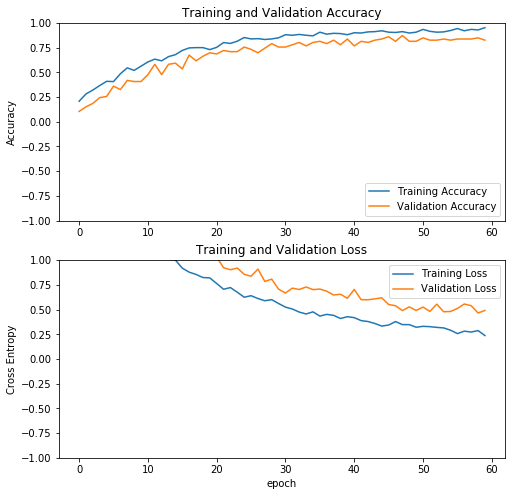

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
classes = {0 : 'Chlorophytum comosum' , 1 :  'Ficus Benjamina', 2 :  'grass' , 3 :  'philodendron', 4 :  'wheat'}
# {'Chlorophytum comosum': 0, 'Ficus Benjamina': 1, 'grass': 2, 'philodendron': 3, 'wheat': 4}

Using TensorFlow backend.


Text(0.5, 1.0, 'Predicted:wheat\n Actual type : wheat')

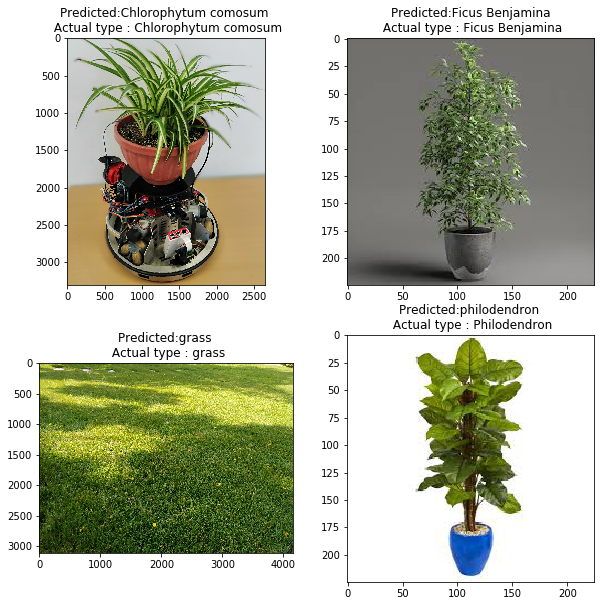

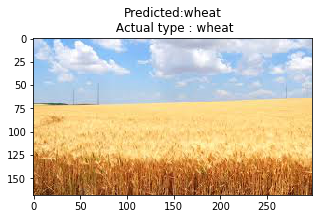

In [38]:
from keras.preprocessing import image
import numpy as np
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg




f = plt.figure(figsize=(10,10))

# print (f)
img_path = 'Chlorophytum comosum.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(221)

plt.imshow(img)


x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)]      )    + " \n Actual type : Chlorophytum comosum" )


img_path = 'Ficus Benjamina.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(222)

plt.imshow(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)]      )    + "\n Actual type : Ficus Benjamina" )


img_path = 'grass.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(223)

plt.imshow(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)] ) + " \n Actual type : grass" )

img_path = "Philodendron.jpg"
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(224)

plt.imshow(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)







plt.title('Predicted:' + str( classes[np.argmax(preds)]      ) + " \n Actual type : Philodendron" )





f = plt.figure(figsize=(5,5))


img_path = 'wheat.jfif'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)


plt.imshow(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)]      ) + "\n Actual type : wheat" )


Text(0.5, 1.0, 'Predicted:grass \n Actual type : grass')

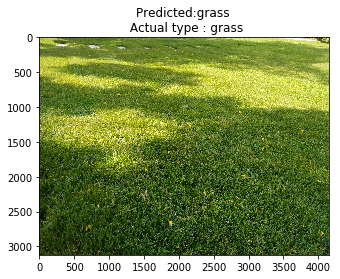

In [39]:
img_path = 'grass.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(223)

plt.imshow(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)] ) + " \n Actual type : grass" )

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'Predicted:grass \n Actual type : grass')

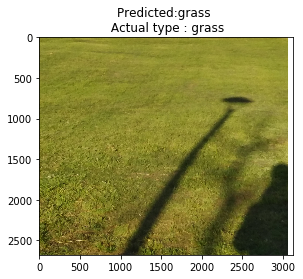

In [40]:
img_path = 'grass2.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(223)

plt.imshow(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)] ) + " \n Actual type : grass" )

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'Predicted:grass \n Actual type : grass')

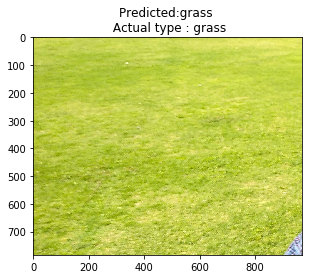

In [41]:
img_path = 'grass3.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(223)

plt.imshow(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)] ) + " \n Actual type : grass" )

In [42]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/content/drive/My Drive/plant_data/test",
    batch_size=1,
    class_mode='categorical',
    target_size=(224, 224))

Found 51 images belonging to 5 classes.


In [0]:
predict = model2.evaluate_generator(test_generator,steps = 20)

In [44]:
predict

[0.27179329479113223, 1.0]

In [45]:
model.metrics_names

['loss', 'acc']